In [215]:
import datetime

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import plotly
import pandas as pd
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import plotly.express as px

from category_encoders import TargetEncoder
import scipy
from scipy.stats import normaltest
import seaborn as sns
import sklearn
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error,  mean_absolute_percentage_error, r2_score
#from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import linear_model

from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder

import sys

import time
#%matplotlib inline

import warnings
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from category_encoders import *
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import AdaBoostRegressor
import lightgbm as lgb
from sklearn import set_config



warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
sns.set(style="whitegrid")

Dans ce deuxième notebook, nous nous concentrons sur la modélisation de la variable "Site EnergyUse" testant les meme algo que pour les predictions de CO2. C'est a dire:
Regression linéaire, RandomForest, AdaBoost, LGBM.  
L'objectif reste le meme : évaluer la capacité des modèles à prédire  la consommation d'énergie sur site des bâtiments. Nous continuerons à utiliser les métriques meme d'évaluation telles que le coefficient de détermination (R2), la racine de l'erreur quadratique moyenne (RMSE) et l'erreur absolue moyenne (MAE), ainsi que le temps d'execution.

In [216]:
#Chargement des données nettoyées
data2 = pd.read_csv("building_energy_cleaned.csv")
data2.head()
data2.shape

(1633, 43)

In [217]:
data2.describe()

,Unnamed: 0,OSEBuildingID,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SourceEUI(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity,BuildingAge,most_use_steam,most_use_natural,most_use_electric,use_stream,use_electricity,use_natural,percent_steam,percent_natural,percent_electricity,LargestPropertyUseTypeGFA_rate,SecondLargestPropertyUseTypeGFA_rate,ThirdLargestPropertyUseTypeGFA_rate,PropertyGFABuilding(s)_rate,PropertyGFAParking_rate,GFAPerBuilding,GFAPerFloor,NumberOfAllUseTypes,TotalGHGEmissionsLog,SiteEnergyUse(kBtu)Log
count,1633.00000,1633.000000,1633.000000,1633.000000,1633.000000,1633.000000,1.633000e+03,1082.000000,1633.000000,1.633000e+03,1.633000e+03,1.633000e+03,1633.000000,1633.000000,1633.000000,1633.000000,1633.000000,1633.000000,1633.000000,1633.000000,1631.000000,1631.000000,1631.000000,1629.000000,1633.000000,1633.000000,1633.000000,1633.000000,1.633000e+03,1633.000,1633.000000,1633.000000,1633.000000
mean,816.00000,16378.946724,47.616073,-122.332881,1.201470,4.154317,1.191986e+05,65.158965,178.075505,5.229307e+05,5.911379e+06,2.000854e+06,1.632554,53.971219,0.014697,0.245560,0.738518,0.069810,0.998163,0.721372,2.159579,28.070576,69.769845,86.905623,12.404770,2.209100,93.786926,6.213074,1.076542e+05,inf,25.314146,1.747538,6.485044
std,471.55081,13802.461636,0.048185,0.024499,2.951893,6.625352,2.986863e+05,28.369843,184.393952,5.568926e+06,2.096914e+07,9.461064e+06,2.352201,32.683228,0.120373,0.430551,0.439576,0.254905,0.042835,0.448462,9.248793,26.393241,26.205669,30.723538,17.181598,6.232493,14.112650,14.112650,1.836394e+05,NaN,20.556978,0.623243,0.582438
min,0.00000,1.000000,47.499170,-122.411820,1.000000,0.000000,1.128500e+04,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.650000,0.000000,0.000000,10.500000,0.000000,4.300000e+03,221.697,5.000000,0.000000,0.000000
25%,408.00000,586.000000,47.585280,-122.343180,1.000000,1.000000,2.940000e+04,48.000000,78.699997,0.000000e+00,7.412870e+05,0.000000e+00,0.360000,27.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,48.620163,69.080000,0.000000,0.000000,100.000000,0.000000,2.880000e+04,13292.550,12.000000,1.340444,6.103277
50%,816.00000,21172.000000,47.612400,-122.332890,1.000000,2.000000,4.924300e+04,73.000000,132.399994,0.000000e+00,1.640689e+06,5.161970e+05,0.890000,50.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,24.656174,69.649435,96.110000,0.000000,0.000000,100.000000,0.000000,4.769900e+04,22913.528,20.000000,1.710287,6.418150
75%,1224.00000,24602.000000,47.649750,-122.321800,1.000000,4.000000,1.060000e+05,89.000000,205.300003,0.000000e+00,4.967236e+06,1.529064e+06,1.910000,86.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,49.695059,99.935035,100.000000,23.820000,0.000000,100.000000,0.000000,1.007340e+05,38210.000,33.000000,2.163728,6.844088
max,1632.00000,50226.000000,47.733870,-122.258640,111.000000,99.000000,9.320156e+06,100.000000,2620.000000,1.349435e+08,6.570744e+08,2.979090e+08,34.090000,116.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,76.698765,100.000000,100.000000,642.680000,145.210000,92.910000,100.000000,89.500000,2.200000e+06,inf,255.000000,4.227166,8.941474


In [218]:
if 'Unnamed: 0' in data2.columns:
    data2.drop('Unnamed: 0', axis=1, inplace=True)

In [219]:
data2[(data2.GFAPerBuilding == np.inf) | (data2.GFAPerFloor == np.inf)].head()

,OSEBuildingID,BuildingType,PrimaryPropertyType,TaxParcelIdentificationNumber,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,SourceEUI(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),ComplianceStatus,GHGEmissionsIntensity,BuildingAge,most_use_steam,most_use_natural,most_use_electric,use_stream,use_electricity,use_natural,percent_steam,percent_natural,percent_electricity,LargestPropertyUseTypeGFA_rate,SecondLargestPropertyUseTypeGFA_rate,ThirdLargestPropertyUseTypeGFA_rate,PropertyGFABuilding(s)_rate,PropertyGFAParking_rate,GFAPerBuilding,GFAPerFloor,NumberOfAllUseTypes,TotalGHGEmissionsLog,SiteEnergyUse(kBtu)Log,Age_cat
155,267,NonResidential,Hospitality,6792120000,DOWNTOWN,47.61275,-122.33330,1.0,0,934292,"Hotel, Other, Parking, Restaurant, Retail Store",Hotel,Parking,Restaurant,NaN,272.899994,0.0,39364114.0,25683162.0,Compliant,1.75,17,0,0,1,0,1,1,0.000000,39.483839,60.516161,53.04,46.96,5.32,100.0,0.0,934292.0,inf,47,3.214701,7.813229,"(10, 20]"
467,656,NonResidential,Healthcare,8725990000,EAST,47.60979,-122.32298,1.0,0,225982,Medical Office,Medical Office,no information,no information,53.0,246.899994,7815663.0,12744957.0,0.0,Compliant,3.06,12,0,0,1,1,1,0,38.012779,0.000000,61.987221,88.58,0.00,0.00,100.0,0.0,225982.0,inf,14,2.840808,7.313036,"(10, 20]"
468,657,NonResidential,Mixed Use,8729740000,DOWNTOWN,47.61783,-122.33729,1.0,0,516407,"Financial Office, Hotel, Multifamily Housing, ...",Parking,Multifamily Housing,Hotel,31.0,199.199997,0.0,29432803.0,9970512.0,Compliant,1.42,10,0,0,1,0,1,1,0.000000,25.303739,74.696261,74.59,65.89,13.10,100.0,0.0,516407.0,inf,99,2.866713,7.595533,"(0, 10]"
540,758,NonResidential,Other,6600470000,DOWNTOWN,47.61289,-122.33531,1.0,0,947987,"Office, Other - Entertainment/Public Assembly,...",Other - Mall,Other - Entertainment/Public Assembly,Restaurant,NaN,195.600006,0.0,46510954.0,0.0,Compliant,0.34,17,0,0,1,0,1,0,0.000000,0.000000,100.000000,59.25,10.55,8.44,100.0,0.0,947987.0,inf,71,2.512217,7.667555,"(10, 20]"
1053,23311,NonResidential,Healthcare,8590900646,EAST,47.60862,-122.32372,1.0,0,274568,"Medical Office, Parking",Medical Office,Parking,no information,52.0,235.500000,13296249.0,12015275.0,0.0,Compliant,4.04,71,1,0,0,1,1,0,52.530417,0.000000,47.469583,83.09,49.52,0.00,100.0,0.0,274568.0,inf,23,3.045741,7.403318,"(70, 80]"


In [220]:
data2['GFAPerFloor'] = np.where(((data2.GFAPerFloor == np.inf) & (data2.NumberofFloors == 0)),0, data2.GFAPerFloor)

In [221]:
data = data2[[ "NumberofFloors",  "BuildingAge" ,"NumberofBuildings",
                "percent_electricity",
              "LargestPropertyUseTypeGFA_rate","SecondLargestPropertyUseTypeGFA_rate" ,"ThirdLargestPropertyUseTypeGFA_rate",  
              "PropertyGFAParking_rate",
              'SiteEnergyUse(kBtu)Log',  "PrimaryPropertyType",
             "Neighborhood" ,"NumberOfAllUseTypes",'GFAPerBuilding','GFAPerFloor',
             'LargestPropertyUseType',"SecondLargestPropertyUseType", "ThirdLargestPropertyUseType"]]


In [222]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1633 entries, 0 to 1632
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   NumberofFloors                        1633 non-null   int64  
 1   BuildingAge                           1633 non-null   int64  
 2   NumberofBuildings                     1633 non-null   float64
 3   percent_electricity                   1631 non-null   float64
 4   LargestPropertyUseTypeGFA_rate        1629 non-null   float64
 5   SecondLargestPropertyUseTypeGFA_rate  1633 non-null   float64
 6   ThirdLargestPropertyUseTypeGFA_rate   1633 non-null   float64
 7   PropertyGFAParking_rate               1633 non-null   float64
 8   SiteEnergyUse(kBtu)Log                1633 non-null   float64
 9   PrimaryPropertyType                   1633 non-null   object 
 10  Neighborhood                          1633 non-null   object 
 11  NumberOfAllUseTyp

In [223]:
data.head()

,NumberofFloors,BuildingAge,NumberofBuildings,percent_electricity,LargestPropertyUseTypeGFA_rate,SecondLargestPropertyUseTypeGFA_rate,ThirdLargestPropertyUseTypeGFA_rate,PropertyGFAParking_rate,SiteEnergyUse(kBtu)Log,PrimaryPropertyType,Neighborhood,NumberOfAllUseTypes,GFAPerBuilding,GFAPerFloor,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
0,12,89,1.0,54.605997,100.00,0.00,0.00,0.00,6.858920,Hospitality,DOWNTOWN,5,88434.0,7369.500,Hotel,no information,no information
1,11,20,1.0,38.660907,80.99,14.55,4.46,14.55,6.923655,Hospitality,DOWNTOWN,26,103566.0,9415.091,Hotel,Parking,Restaurant
2,41,47,1.0,68.230746,79.12,0.00,0.00,20.57,7.860859,Hospitality,DOWNTOWN,5,956110.0,23319.756,Hotel,no information,no information
3,10,90,1.0,40.751933,100.00,0.00,0.00,0.00,6.832163,Hospitality,DOWNTOWN,5,61320.0,6132.000,Hotel,no information,no information
4,18,36,1.0,37.880171,70.31,38.73,0.00,35.31,7.151450,Hospitality,DOWNTOWN,29,175580.0,9754.444,Hotel,Parking,Swimming Pool


In [224]:
def display_corr(data):
    numeric_data = data.select_dtypes(include=['number', 'bool'])

    # Compute correlation
    corr = round(numeric_data.corr(),2)

    display(corr)
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(7, 6))


    sns.heatmap(corr, mask=mask, cmap="coolwarm",annot= True, fmt = ".2f", center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

,NumberofFloors,BuildingAge,NumberofBuildings,percent_electricity,LargestPropertyUseTypeGFA_rate,SecondLargestPropertyUseTypeGFA_rate,ThirdLargestPropertyUseTypeGFA_rate,PropertyGFAParking_rate,SiteEnergyUse(kBtu)Log,NumberOfAllUseTypes,GFAPerBuilding,GFAPerFloor
NumberofFloors,1.00,-0.10,-0.02,0.16,-0.07,0.09,0.03,0.19,0.40,0.04,0.68,-0.09
BuildingAge,-0.10,1.00,0.03,-0.17,0.00,-0.08,0.04,-0.34,-0.24,-0.00,-0.21,-0.12
NumberofBuildings,-0.02,0.03,1.00,0.00,0.04,-0.02,-0.01,-0.02,0.16,-0.00,-0.02,0.09
percent_electricity,0.16,-0.17,0.00,1.00,-0.09,0.11,0.04,0.21,-0.01,-0.01,0.16,-0.02
LargestPropertyUseTypeGFA_rate,-0.07,0.00,0.04,-0.09,1.00,-0.41,-0.33,-0.27,-0.07,-0.33,-0.11,0.01
SecondLargestPropertyUseTypeGFA_rate,0.09,-0.08,-0.02,0.11,-0.41,1.00,0.42,0.25,0.17,0.39,0.14,0.00
ThirdLargestPropertyUseTypeGFA_rate,0.03,0.04,-0.01,0.04,-0.33,0.42,1.00,0.06,0.10,0.52,0.06,0.01
PropertyGFAParking_rate,0.19,-0.34,-0.02,0.21,-0.27,0.25,0.06,1.00,0.26,0.01,0.24,0.02
SiteEnergyUse(kBtu)Log,0.40,-0.24,0.16,-0.01,-0.07,0.17,0.10,0.26,1.00,0.10,0.55,0.29
NumberOfAllUseTypes,0.04,-0.00,-0.00,-0.01,-0.33,0.39,0.52,0.01,0.10,1.00,0.11,0.06


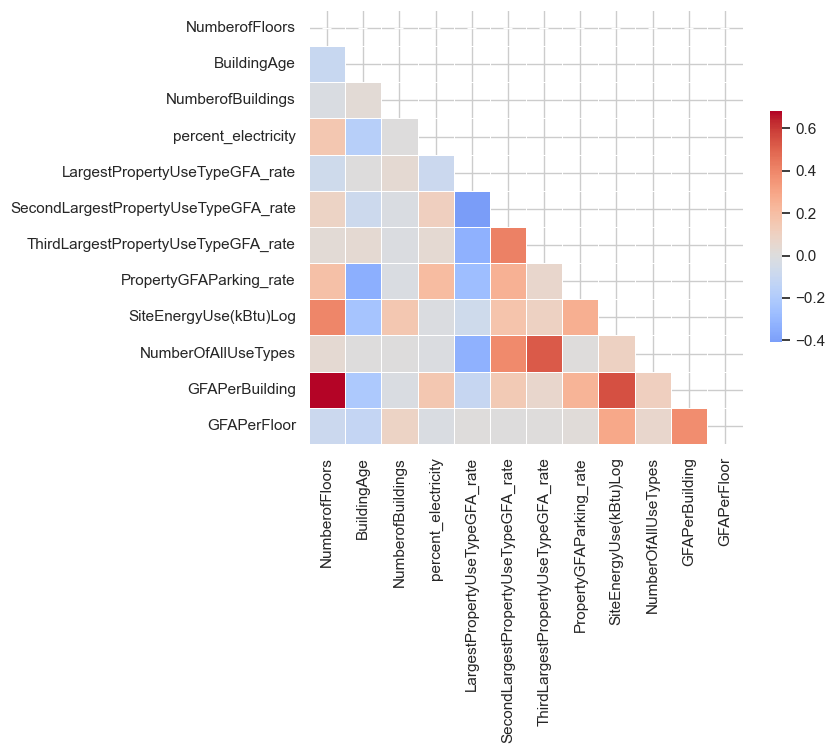

In [225]:
display_corr(data)

In [226]:
model_data = data

## Choix des algorithmes
### Lineaire:
- Regression lineaire multiples
 ensembliste:  
- AdaBoost, ou Adaptive Boosting, est un algorithme d'apprentissage automatique qui appartient à la famille des méthodes d'ensemble (ensemble methods). L'objectif d'AdaBoost est d'améliorer la performance d'un modèle en combinant plusieurs modèles d'apprentissage faibles pour former un modèle fort. Un modèle faible est un modèle qui a une performance légèrement meilleure que le hasard, par exemple, un classifieur légèrement meilleur qu'une prédiction aléatoire.  
- Random Forest : Les forêts aléatoires construisent plusieurs arbres de décision indépendants et les combinent pour réduire le surajustement et améliorer la robustesse du modèle.  
- SVR 


## Pipeline

## models pour SiteEnergyUse

In [227]:

#Les variables numériques et catégorielles doivent etre standardisées et encodées.

model_data.dropna(how = 'any', inplace=True)
X = model_data.drop(['SiteEnergyUse(kBtu)Log'],axis=1) #TotalGHGEmissions
y = model_data['SiteEnergyUse(kBtu)Log']


# Check for NaN

col_int =  list(X.columns[X.dtypes == 'int64' ])
col_float = list(X.columns[X.dtypes == 'float64'])
col_cate = list(X.columns[X.dtypes == 'object'])

#set_config(transform_output="pandas")

col_num_tr = Pipeline(steps = [
   ("imputer", SimpleImputer(strategy="mean")),('scaler', StandardScaler())])

col_cate_tr = Pipeline(steps = [
   ("encoder", OneHotEncoder(handle_unknown="ignore"))])



preprocessor = ColumnTransformer(
   transformers=[
       ('numeric',  col_num_tr, col_int + col_float),
       ('cat', col_cate_tr, col_cate)], remainder='passthrough')

preprocessor.fit_transform(X)
preprocessor


ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['NumberofFloors', 'BuildingAge',
                                  'NumberOfAllUseTypes', 'NumberofBuildings',
                                  'percent_electricity',
                                  'LargestPropertyUseTypeGFA_rate',
                                  'SecondLargestPropertyUseTypeGFA_rate',
                                  'ThirdLargestPropertyUseTypeGFA_rate',
                                  'PropertyGFAParking_rate', 'GFAPerBuilding',
                                  'GFAPerFloor']),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['PrimaryPropertyType', 'Neighborhood',
                                  'LargestPropertyUseType',
                                  'SecondLargestPropertyUseType',
                                  'ThirdLargestPropertyUseType'])])

Integer les modeles au Pipeline

In [228]:

linear = Pipeline(steps=[('prepa',preprocessor),('linear',linear_model.LinearRegression())])

forest = Pipeline(steps=[('prepa',preprocessor),('forest',RandomForestRegressor(random_state=0))])
Ada = Pipeline(steps=[('prepa',preprocessor),('ADA',AdaBoostRegressor(random_state=0))])
Lgbm = Pipeline(steps=[('prepa',preprocessor),('Lgbm',lgb.LGBMRegressor())])
Svr = Pipeline(steps=[('prepa',preprocessor),('Svr',SVR(kernel='linear'))])
dum = Pipeline(steps=[('prepa',preprocessor),('dum',DummyRegressor())])
forest

Pipeline(steps=[('prepa',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofFloors',
                                                   'BuildingAge',
                                                   'NumberOfAllUseTypes',
                                                   'NumberofBuildings',
                                                   'percent_electricity',
                                                   'LargestPropertyUseTypeGFA_rate',
                                                   'SecondLargestPropertyUseTypeGFA_rate',
                                                   'ThirdLargestPropertyUseTypeGFA_rate',
                                                   'PropertyGFAParking_rate',
                                                   'GFAPerBuilding',
                                                   'GFAPerFloor']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['PrimaryPropertyType',
                                                   'Neighborhood',
                                                   'LargestPropertyUseType',
                                                   'SecondLargestPropertyUseType',
                                                   'ThirdLargestPropertyUseType'])])),
                ('forest', RandomForestRegressor(random_state=0))])

In [229]:

'''X_transformed = preprocessor.fit_transform(X)
X= X_transformed.toarray()
display(X.shape)'''
# Apply only the first step transformation


X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=0)
# Check for infinity

forest.fit(X_train, y_train)

print('train set: ', X_train.shape)
print('test set: ', X_test.shape)
display(X.info())
print("model score: %.3f" % forest.score(X_test, y_test))

train set:  (1301, 16)
test set:  (326, 16)
<class 'pandas.core.frame.DataFrame'>
Index: 1627 entries, 0 to 1632
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   NumberofFloors                        1627 non-null   int64  
 1   BuildingAge                           1627 non-null   int64  
 2   NumberofBuildings                     1627 non-null   float64
 3   percent_electricity                   1627 non-null   float64
 4   LargestPropertyUseTypeGFA_rate        1627 non-null   float64
 5   SecondLargestPropertyUseTypeGFA_rate  1627 non-null   float64
 6   ThirdLargestPropertyUseTypeGFA_rate   1627 non-null   float64
 7   PropertyGFAParking_rate               1627 non-null   float64
 8   PrimaryPropertyType                   1627 non-null   object 
 9   Neighborhood                          1627 non-null   object 
 10  NumberOfAllUseTypes                   1627 no

None

model score: 0.703


In [230]:

def evaluate_model(model, nom_model, X, y, pipelines, cv=9):
   
    # Effectuer la validation croisée
    score = cross_validate(model, X, y, cv=cv,
                           scoring=('neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error'),
                           return_train_score=True)

    # Calculer les métriques moyennes
    rmse_train = -score['train_neg_root_mean_squared_error'].mean()
    rmse_test = -score['test_neg_root_mean_squared_error'].mean()
    r2_train = score['train_r2'].mean()
    r2_test = score['test_r2'].mean()
    absolute_test = -score['test_neg_mean_absolute_error'].mean()
    fit_time_test = score['fit_time'].mean()
    score_time_test = score['score_time'].mean()

    # Créer un DataFrame avec les résultats
    resultat_df = pd.DataFrame({
        'RMSE Train': [rmse_train],
        'RMSE Test': [rmse_test],
        'R2 Train': [r2_train],
        'R2 Test': [r2_test],
        'MAE Test': [absolute_test],
        'Fit Time Test': [fit_time_test],
        'Score Time Test': [score_time_test]
    })

    return resultat_df


### Evaluation des modeles sans tunning

In [231]:
def evaluate_models(models, X, y):
    # Dictionnaire pour stocker les résultats
    results = {}

    # Parcours de chaque modèle
    for name, model in models.items():
        # Effectuer une validation croisée
        metrics = ['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error']
        scores = cross_validate(model, X, y, cv=10, scoring=metrics, return_train_score=True)

        # Stocker les résultats
        results[name] = {
            'RMSE Train': -scores['train_neg_root_mean_squared_error'].mean(),
            'RMSE Test': -scores['test_neg_root_mean_squared_error'].mean(),
            'R2 Train': scores['train_r2'].mean(),
            'R2 Test': scores['test_r2'].mean(),
            'Absolute': -scores['train_neg_mean_absolute_error'].mean(),
            'Fit Time': scores['fit_time'].mean(),
            'Score Time': scores['score_time'].mean()
        }

    # Créer un DataFrame à partir des résultats
    result_df = pd.DataFrame(results).T

    # Renommer les index du DataFrame
    result_df.index = models.keys()

    return result_df

In [232]:
models = {'linear': linear, 'forest': forest, 'adaboost': Ada, 'Lgbm':Lgbm, "Svr":Svr,"dum": dum}
result_df = evaluate_models(models, X, y)
display(result_df)

,RMSE Train,RMSE Test,R2 Train,R2 Test,Absolute,Fit Time,Score Time
linear,0.311770,0.381027,0.688995,0.319458,0.236582,0.032142,0.004117
forest,0.106763,0.292617,0.963514,0.605883,0.077552,2.359493,0.010038
adaboost,0.308728,0.338541,0.695048,0.467069,0.250230,0.169683,0.008901
Lgbm,0.135678,0.292439,0.941063,0.606311,0.099414,0.127956,0.004915
Svr,0.331649,0.376089,0.647853,0.323381,0.231726,0.330610,0.008588
dum,0.559292,0.573190,0.000000,-0.527984,0.444075,0.006436,0.003111


## Visualisation 

In [233]:
def graph_melted(melted_baseline):
    melted_baseline = melted_baseline.rename(columns={'index': 'Model'})    
    #display(melted_baseline)
# graphique

    plt.figure(figsize=(5, 4))

    sns.barplot(x='Model', y='Value', hue='Metric', data=melted_baseline, palette='muted', dodge=True, width=0.2)

    plt.title('Comparaison des modèles  - Metric')
    plt.xlabel('Modèle')
    plt.ylabel('Résultat')
    plt.legend(title='Metric')

    plt.show()

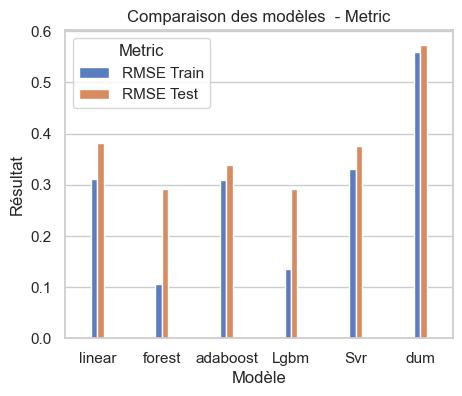

In [234]:

# Melt DataFrame pour regrouper les colonnes 'Score Time' et 'RMSE' en une seule colonne
melted_baseline = pd.melt(result_df.reset_index(), id_vars='index', value_vars=['RMSE Train', 'RMSE Test'],
                          var_name='Metric', value_name='Value')

graph_melted(melted_baseline)


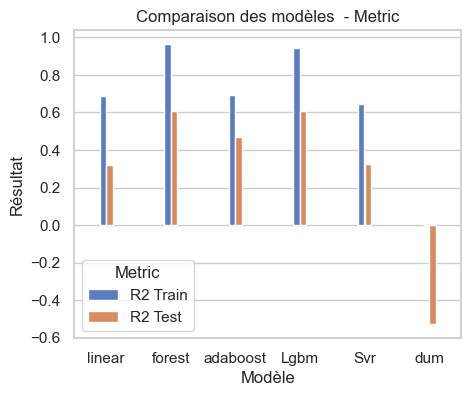

In [235]:
# Melt DataFrame pour regrouper les colonnes 'Score Time' et 'RMSE' en une seule colonne
melted_baseline = pd.melt(result_df.reset_index(), id_vars='index', value_vars=['R2 Train', 'R2 Test'],
                          var_name='Metric', value_name='Value')

graph_melted(melted_baseline)

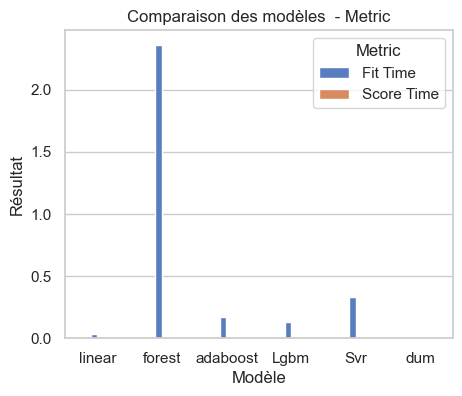

In [236]:
# Melt DataFrame pour regrouper les colonnes 'Score Time' et 'RMSE' en une seule colonne
melted_baseline = pd.melt(result_df.reset_index(), id_vars='index', value_vars=['Fit Time', 'Score Time'],
                          var_name='Metric', value_name='Value')

graph_melted(melted_baseline)

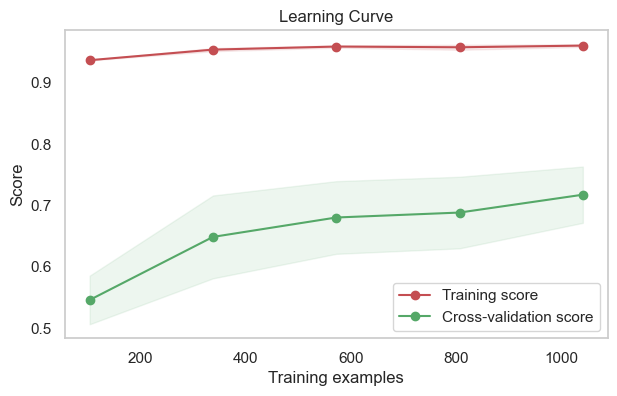

In [237]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure(figsize=(7, 4))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


plot_learning_curve(forest, "Learning Curve", X_train, y_train, cv=5)

plt.show()


Graphique pour test set

## Hyperparametre

### regression lineaire
fit_intercept : C'est un booléen qui décide si un terme constant (également appelé biais ou intercept) doit être ajusté. Si True, le modèle ajustera un terme constant à la matrice de conception X. Si False, aucun terme constant ne sera ajusté. Par défaut, il est défini sur True.

,RMSE Train,RMSE Test,R2 Train,R2 Test,MAE Test,Fit Time Test,Score Time Test
0,0.311236,0.387061,0.689761,0.320466,0.292915,0.032298,0.004568


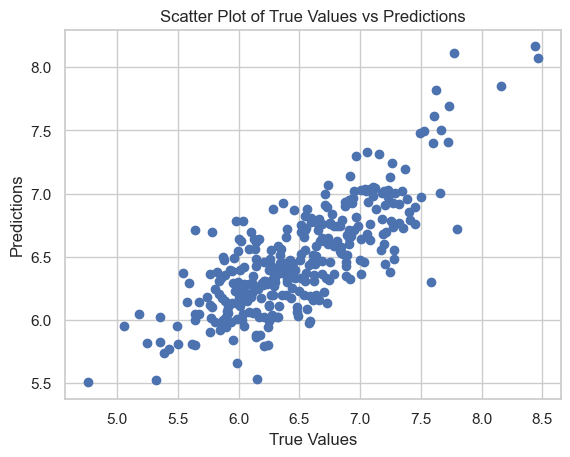

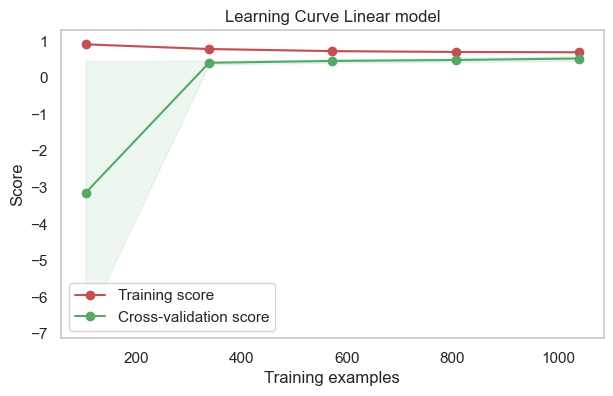

In [238]:
linear_model = Pipeline([
    ('prepa', preprocessor),
    ('linear', linear_model.LinearRegression(fit_intercept=True))
])
linear_model.fit(X_train, y_train)
predictions = linear_model.predict(X_test)
pipelines = {}


result_linear = evaluate_model(linear_model, 'linear', X, y, pipelines)
display(result_linear)


plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Scatter Plot of True Values vs Predictions')
plt.show()
plot_learning_curve(linear_model, "Learning Curve Linear model", X_train, y_train, cv=5)
plt.show()

### Random forest

n_estimators (int = 100): Nombre d'arbres dans la forêt. Plus ce nombre est élevé, mieux c'est, mais cela augmente le coût de calcul. 
max_features : Le nombre de caractéristiques à considérer lors de la recherche de la meilleure séparation.  
max_depth : La profondeur maximale des arbres. Une profondeur plus grande permet au modèle de capturer des relations plus complexes dans les données, mais cela peut entraîner un surajustement.

min_samples_split : Le nombre minimum d'échantillons requis pour diviser un nœud interne. Il contrôle la croissance de l'arbre en empêchant la division de nœuds ayant un nombre d'échantillons inférieur à la valeur spécifiée.

min_samples_leaf : Le nombre minimum d'échantillons requis pour être dans un nœud feuille. Il contrôle la taille minimale des feuilles dans l'arbre.

bootstrap : Indique si l'échantillonnage avec remplacement doit être utilisé pour construire des arbres. Si False, l'échantillonnage sans remplacement est utilisé, ce qui signifie que chaque arbre est construit sur un sous-ensemble unique des données.

In [239]:
# Instancier le modèle avec le préprocesseur dans le pipeline
forest_pipeline = Pipeline(steps=[
    ('prepa', preprocessor),
    ('forest', RandomForestRegressor(random_state=42))
])

# Définir la grille des hyperparamètres à rechercher
param_grid_rf = {
    'forest__n_estimators': [100, 125,150, 195,200],# test 190 - 220
    'forest__max_features': [1, 0.5, 0.2],
    'forest__random_state': [1,2, 3, 4],
    'forest__min_samples_split':[1, 2,3, 4],
    'forest__min_samples_leaf':[0,1,2]
}

grid_search = GridSearchCV(
    forest_pipeline, param_grid=param_grid_rf, 
    cv=5, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')



grid_search.fit(X_train, y_train)

print("Meilleurs hyperparamètres : ", grid_search.best_params_)

# Prédire sur l'ensemble de test avec les meilleurs hyperparamètres
y_pred = grid_search.predict(X_test)

# Les performances du modèle
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Calculate RMSE as the square root of MSE
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error : {mse}")
print(f"Root Mean Squared Error : {rmse}")
print(f"R2 : {r2}")

Meilleurs hyperparamètres :  {'forest__max_features': 0.5, 'forest__min_samples_leaf': 1, 'forest__min_samples_split': 3, 'forest__n_estimators': 100, 'forest__random_state': 1}
Mean Squared Error : 0.09354327009323006
Root Mean Squared Error : 0.30584844301259745
R2 : 0.7198093042973517


,RMSE Train,RMSE Test,R2 Train,R2 Test,MAE Test,Fit Time Test,Score Time Test
0,0.112435,0.292946,0.959504,0.603853,0.214828,2.314951,0.01588


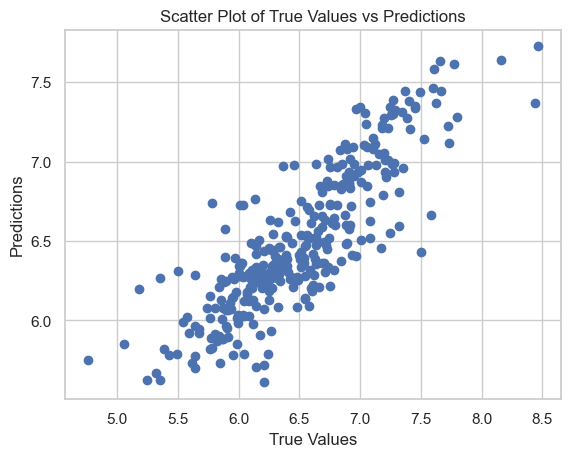

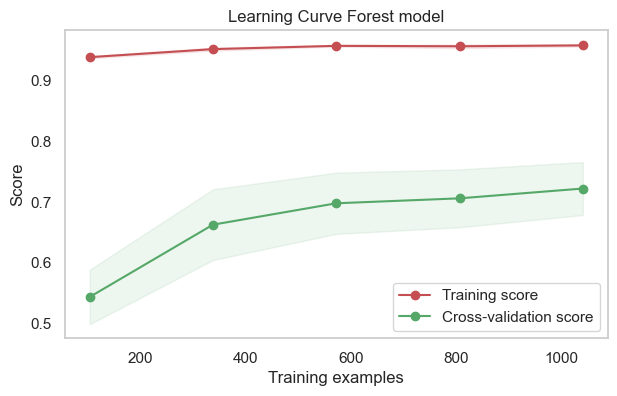

In [240]:
forest_model = Pipeline(steps=[
    ('prepa', preprocessor),
    ('forest', RandomForestRegressor(n_estimators=200, bootstrap=True, max_features=0.5, 
                                      min_samples_split=3, min_samples_leaf=1, random_state=1))
])
# Ensuite, vous pouvez utiliser ce pipeline pour ajuster votre modèle
# Ensuite, vous pouvez utiliser ce pipeline pour ajuster votre modèle
forest_model.fit(X_train, y_train)

# Et également utiliser le pipeline pour faire des prédictions
predictions = forest_model.predict(X_test)
pipelines = {}
result_forest = evaluate_model(forest_model, 'forest', X, y, pipelines)
display(result_forest)
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Scatter Plot of True Values vs Predictions')
plt.show()
#display(result_forest, predictions)

plot_learning_curve(forest_model, "Learning Curve Forest model", X_train, y_train, cv=5)
plt.show()

### AdaBoost
### HyperParametre:
n_estimators : Le nombre d'étapes de renforcement à effectuer. Il représente le nombre de faibles apprenants à former séquentiellement.  
learning_rate : Il réduit la contribution de chaque faible apprenant. Un taux d'apprentissage plus bas nécessite plus de faibles apprenants.  
base_estimator : L'estimateur de base à partir duquel l'ensemble renforcé est construit. La valeur par défaut est un arbre de décision avec une profondeur de 1 (DecisionTreeRegressor(max_depth=1)).  

In [241]:
# Instancier le modèle avec le préprocesseur dans le pipeline
ada_pipeline = Pipeline(steps=[
    ('prepa', preprocessor),
    ('ada', AdaBoostRegressor(random_state=42))
])

# Définir la grille des hyperparamètres à rechercher
param_grid_ada = {
    'ada__n_estimators': [70,80,90,100,110],# 90 -110
    'ada__learning_rate': [1,2,5],
    "ada__loss": ['linear', 'square', 'exponential'],
    "ada__random_state":[1,2,5]
}

grid_search = GridSearchCV(
    ada_pipeline, param_grid=param_grid_ada, 
    cv=7, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

print("Meilleurs hyperparamètres : ", grid_search.best_params_)

# Prédire sur l'ensemble de test avec les meilleurs hyperparamètres
y_pred = grid_search.predict(X_test)

# Les performances du modèle
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Calculate RMSE as the square root of MSE
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error : {mse}")
print(f"Root Mean Squared Error : {rmse}")
print(f"R2 : {r2}")

Meilleurs hyperparamètres :  {'ada__learning_rate': 5, 'ada__loss': 'exponential', 'ada__n_estimators': 110, 'ada__random_state': 5}
Mean Squared Error : 0.12155738407226094
Root Mean Squared Error : 0.3486508053515163
R2 : 0.635898467339707


Mean Squared Error: 0.12
R-squared: 0.64


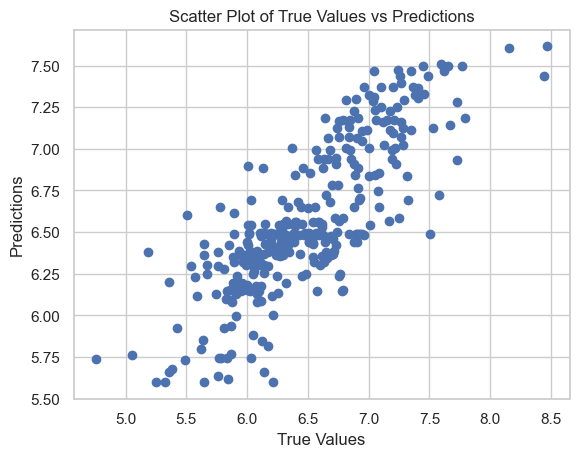

,RMSE Train,RMSE Test,R2 Train,R2 Test,MAE Test,Fit Time Test,Score Time Test
0,0.303768,0.334426,0.704477,0.485113,0.26234,0.295323,0.015483


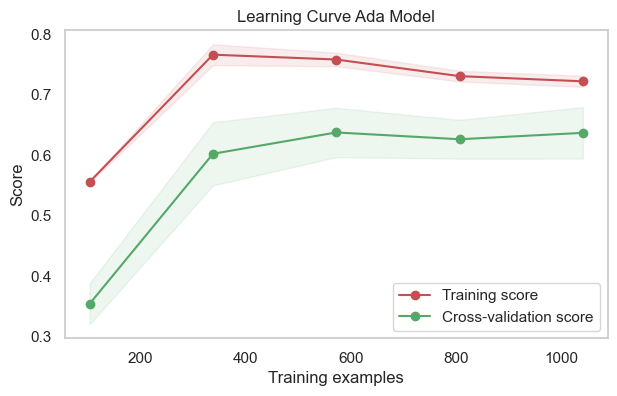

In [242]:
Ada_model = Pipeline([
    ('prepa', preprocessor),
    ('ada', AdaBoostRegressor(n_estimators=110, learning_rate=5, random_state=5, loss='exponential'))
])

# Entraînez le modèle sur les données d'entraînement
Ada_model.fit(X_train, y_train)

# Faites des prédictions sur les données de test
predictions = Ada_model.predict(X_test)

# Évaluez le modèle
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Affichez les résultats de l'évaluation
print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

# Affichez le nuage de points des vraies valeurs par rapport aux prédictions
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Scatter Plot of True Values vs Predictions')
plt.show()
plot_learning_curve(Ada_model, "Learning Curve Ada Model", X_train, y_train, cv=5)

result_Ada = evaluate_model(Ada_model, 'ada', X, y, pipelines)
display(result_Ada)

### LGBM Hyperparametres

In [243]:
# Instancier le modèle avec le préprocesseur dans le pipeline
Lgbm_pipeline = Pipeline(steps=[
    ('prepa', preprocessor),
    ('Lgbm', lgb.LGBMRegressor())
])

# Définir la grille des hyperparamètres à rechercher
param_grid_Lgbm = {
    'Lgbm__n_estimators' :[80, 75,90,100, 110],
    'Lgbm__learning_rate':[0.1, 0.2, 0.3],
    'Lgbm__num_leaves':[15,20,25,30],
    'Lgbm__max_depth':[-1,0,1],
    'Lgbm__min_child_samples':[5, 8, 10, 12,15],
}

grid_search = GridSearchCV(
    Lgbm_pipeline, param_grid=param_grid_Lgbm, 
    cv=6, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

print("Meilleurs hyperparamètres : ", grid_search.best_params_)

# Prédire sur l'ensemble de test avec les meilleurs hyperparamètres
y_pred = grid_search.predict(X_test)

# Les performances du modèle
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error : {mse}")
print(f"Root Mean Squared Error : {rmse}")
print(f"R2 : {r2}")

Meilleurs hyperparamètres :  {'Lgbm__learning_rate': 0.1, 'Lgbm__max_depth': -1, 'Lgbm__min_child_samples': 5, 'Lgbm__n_estimators': 75, 'Lgbm__num_leaves': 20}
Mean Squared Error : 0.0901779575053737
Root Mean Squared Error : 0.300296449371906
R2 : 0.7298894444753525


,RMSE Train,RMSE Test,R2 Train,R2 Test,MAE Test,Fit Time Test,Score Time Test
0,0.165336,0.278416,0.912386,0.63739,0.207454,0.104662,0.005586


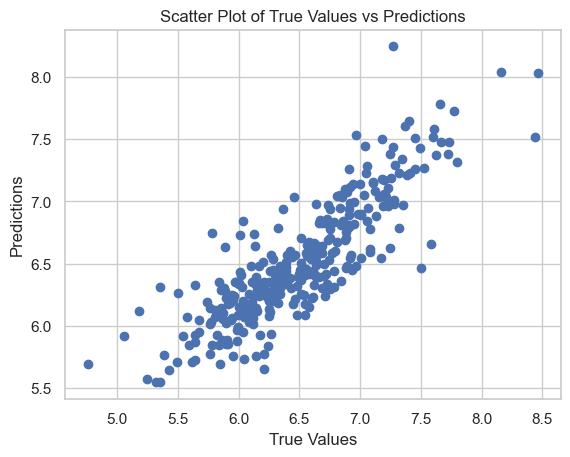

/Users/bahia/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/Users/bahia/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/Users/bahia/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or instal

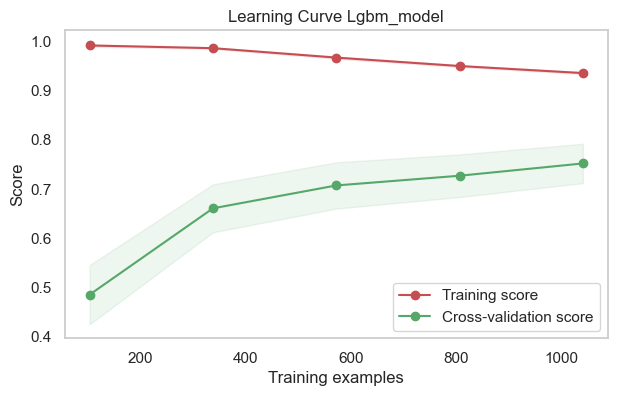

In [244]:

Lgbm_model =Pipeline([
    ('prepa', preprocessor),
    ('Lgbm', lgb.LGBMRegressor(learning_rate=0.1, max_depth=-1,n_estimators=75,num_leaves=20 , min_child_samples=5))
])
# Ensuite, vous pouvez utiliser ce pipeline pour ajuster votre modèle
Lgbm_model.fit(X_train, y_train)

# Et également utiliser le pipeline pour faire des prédictions
predictions = Lgbm_model.predict(X_test)
pipelines = {}

result_Lgbm = evaluate_model(Lgbm_model, 'Lgbm', X, y, pipelines)
display(result_Lgbm)
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Scatter Plot of True Values vs Predictions')
plt.show()
plot_learning_curve(Lgbm_model, "Learning Curve Lgbm_model", X_train, y_train, cv=5)
plt.show()

In [245]:
# Instancier le modèle avec le préprocesseur dans le pipeline
svr_pipeline = Pipeline(steps=[
    ('prepa', preprocessor),
    ('svr', SVR())
])

# Définir la grille des hyperparamètres à rechercher
param_grid_svr = {
    'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
    'svr__C': [0.1, 1, 2],
    'svr__gamma': ['scale', 'auto', 0.1, 1] 
}

grid_search = GridSearchCV(
    svr_pipeline, param_grid=param_grid_svr, 
    cv=5, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

print("Meilleurs hyperparamètres : ", grid_search.best_params_)

# Prédire sur l'ensemble de test avec les meilleurs hyperparamètres
y_pred = grid_search.predict(X_test)

# Les performances du modèle
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Calculate RMSE as the square root of MSE
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error : {mse}")
print(f"Root Mean Squared Error : {rmse}")
print(f"R2 : {r2}")

Meilleurs hyperparamètres :  {'svr__C': 2, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Mean Squared Error : 0.08824618039991555
Root Mean Squared Error : 0.29706258667142105
R2 : 0.7356757075660197


In [246]:
svr_model =Pipeline([
    ('prepa', preprocessor),
    ('svr', SVR(kernel='rbf', C=2, gamma='scale'))
])

result_svr= evaluate_model(svr_model, 'svr', X, y, pipelines)
display(result_svr)

,RMSE Train,RMSE Test,R2 Train,R2 Test,MAE Test,Fit Time Test,Score Time Test
0,0.17147,0.30484,0.905776,0.57387,0.226225,0.08585,0.011327


## Evaluation des models

In [247]:
final_df =[result_linear, result_forest, result_Ada, result_Lgbm, result_svr]

# Concaténez-les verticalement
final_result_df = pd.concat(final_df, axis=0)

# Réinitialisez les index si nécessaire
final_result_df = final_result_df.reset_index(drop=True)

# Définissez les nouveaux index
final_result_df.index = ['linear', 'forest', 'ada', 'lgbm', 'svr']

# Affichez le DataFrame résultant
display(final_result_df)


,RMSE Train,RMSE Test,R2 Train,R2 Test,MAE Test,Fit Time Test,Score Time Test
linear,0.311236,0.387061,0.689761,0.320466,0.292915,0.032298,0.004568
forest,0.112435,0.292946,0.959504,0.603853,0.214828,2.314951,0.015880
ada,0.303768,0.334426,0.704477,0.485113,0.262340,0.295323,0.015483
lgbm,0.165336,0.278416,0.912386,0.637390,0.207454,0.104662,0.005586
svr,0.171470,0.304840,0.905776,0.573870,0.226225,0.085850,0.011327


In [248]:
display(result_df)
display(final_result_df)

,RMSE Train,RMSE Test,R2 Train,R2 Test,Absolute,Fit Time,Score Time
linear,0.311770,0.381027,0.688995,0.319458,0.236582,0.032142,0.004117
forest,0.106763,0.292617,0.963514,0.605883,0.077552,2.359493,0.010038
adaboost,0.308728,0.338541,0.695048,0.467069,0.250230,0.169683,0.008901
Lgbm,0.135678,0.292439,0.941063,0.606311,0.099414,0.127956,0.004915
Svr,0.331649,0.376089,0.647853,0.323381,0.231726,0.330610,0.008588
dum,0.559292,0.573190,0.000000,-0.527984,0.444075,0.006436,0.003111


,RMSE Train,RMSE Test,R2 Train,R2 Test,MAE Test,Fit Time Test,Score Time Test
linear,0.311236,0.387061,0.689761,0.320466,0.292915,0.032298,0.004568
forest,0.112435,0.292946,0.959504,0.603853,0.214828,2.314951,0.015880
ada,0.303768,0.334426,0.704477,0.485113,0.262340,0.295323,0.015483
lgbm,0.165336,0.278416,0.912386,0.637390,0.207454,0.104662,0.005586
svr,0.171470,0.304840,0.905776,0.573870,0.226225,0.085850,0.011327


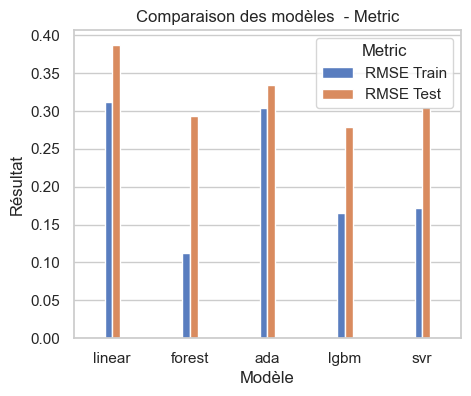

In [249]:
# Melt DataFrame pour regrouper les colonnes 'Score Time' et 'RMSE' en une seule colonne
melted_baseline = pd.melt(final_result_df.reset_index(), id_vars='index', value_vars=['RMSE Train', 'RMSE Test'],
                          var_name='Metric', value_name='Value')

# Renommer les colonnes pour plus de clarté
melted_baseline = melted_baseline.rename(columns={'index': 'Model'})
graph_melted(melted_baseline)



,index,R2 Train,R2 Test
0,linear,0.689761,0.320466
1,forest,0.959504,0.603853
2,ada,0.704477,0.485113
3,lgbm,0.912386,0.637390
4,svr,0.905776,0.573870


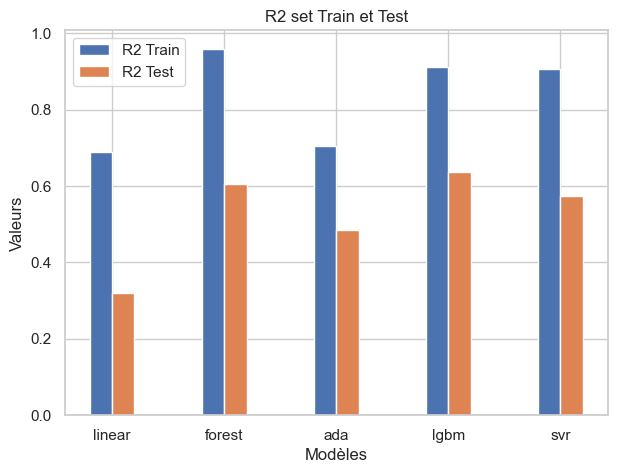

In [250]:
# Créer un DataFrame à partir des données
df_r2 = final_result_df.loc[:, ['R2 Train', 'R2 Test']]
df_r2 = df_r2.reset_index()
display(df_r2)


# Plot

width = 0.2  # Largeur des barres
x = np.arange(len(df_r2))  # Emplacements des barres

fig, ax = plt.subplots(figsize=(7, 5))
rects5 = ax.bar(x - width/2, df_r2['R2 Train'], width, label='R2 Train')
rects6 = ax.bar(x + width/2, df_r2['R2 Test'], width, label='R2 Test')


# Ajouter des étiquettes, des titres, etc.
ax.set_ylabel('Valeurs')
ax.set_xlabel('Modèles')
ax.set_title('R2 set Train et Test')
ax.set_xticks(x)
ax.set_xticklabels(df_r2['index'])
ax.legend()

plt.show()

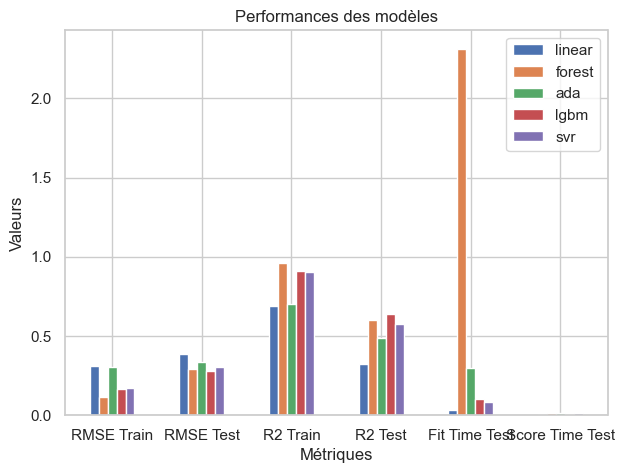

In [251]:
df_results = pd.DataFrame(final_result_df, columns=['RMSE Train', 'RMSE Test', 'R2 Train', 'R2 Test', 'Fit Time Test', 'Score Time Test'])

# Plot
width = 0.1  # Largeur des barres
x = np.arange(len(df_results.columns))  # Emplacements des barres

fig, ax = plt.subplots(figsize=(7, 5))

# Plot pour chaque modèle et chaque métrique
for i, model in enumerate(df_results.index):
    rects = ax.bar(x + width * i, df_results.loc[model], width, label=model)

# Ajouter des étiquettes, des titres, etc.
ax.set_ylabel('Valeurs')
ax.set_xlabel('Métriques')
ax.set_title('Performances des modèles')
ax.set_xticks(x + width * (len(df_results) - 1) / 2)
ax.set_xticklabels(df_results.columns)
ax.legend()

plt.show()

,index,Fit Time Test,Score Time Test
0,linear,0.032298,0.004568
1,forest,2.314951,0.015880
2,ada,0.295323,0.015483
3,lgbm,0.104662,0.005586
4,svr,0.085850,0.011327


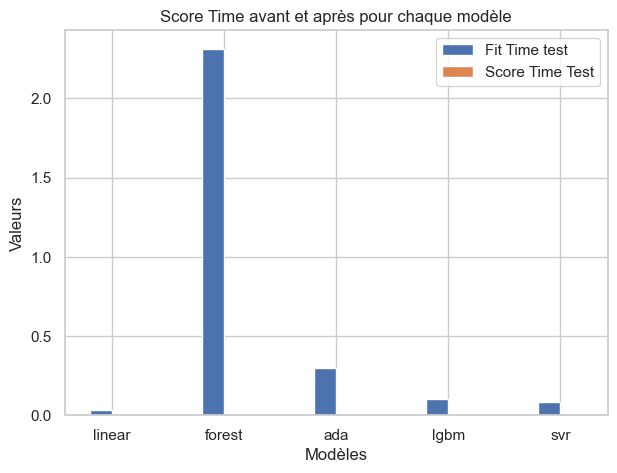

In [252]:
# Créer un DataFrame à partir des données
df_time = final_result_df.loc[:, ['Fit Time Test','Score Time Test']]
df_time = df_time.reset_index()
display(df_time)
# Plot

width = 0.2  # Largeur des barres
x = np.arange(len(df_time))  # Emplacements des barres

fig, ax = plt.subplots(figsize=(7, 5))
rects3 = ax.bar(x - width/2, df_time['Fit Time Test'], width,label='Fit Time test')
rects4 = ax.bar(x + width/2, df_time['Score Time Test'], width,  label='Score Time Test')

# Ajouter des étiquettes, des titres, etc.
ax.set_ylabel('Valeurs')
ax.set_xlabel('Modèles')
ax.set_title('Score Time avant et après pour chaque modèle')
ax.set_xticks(x)
ax.set_xticklabels(df_time['index'])
ax.legend()

plt.show()

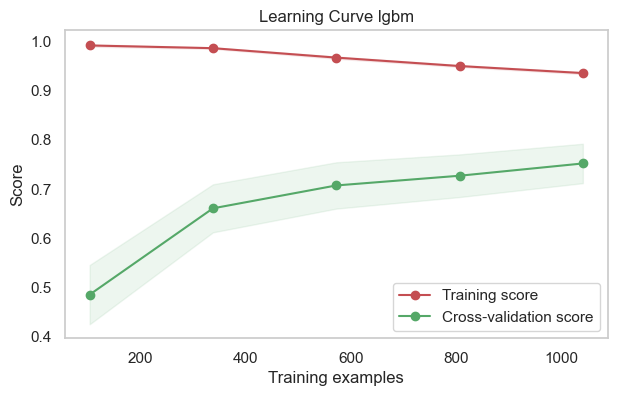

In [253]:
plot_learning_curve(Lgbm_model, "Learning Curve lgbm", X_train, y_train, cv=5)

plt.show()

Après avoir analysé les performances des différents modèles, il apparaît que le LightGBM se distingue comme le choix le plus prometteur. Ses performances en termes de RMSE Test et R2 Test sont solides, et il démontre une efficacité relativement rapide en termes de temps de calcul. 

## Importance des features

In [254]:
import shap

Number of features in X_test: 16
Feature names: Index(['NumberofFloors', 'BuildingAge', 'NumberofBuildings',
       'percent_electricity', 'LargestPropertyUseTypeGFA_rate',
       'SecondLargestPropertyUseTypeGFA_rate',
       'ThirdLargestPropertyUseTypeGFA_rate', 'PropertyGFAParking_rate',
       'PrimaryPropertyType', 'Neighborhood', 'NumberOfAllUseTypes',
       'GFAPerBuilding', 'GFAPerFloor', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType'],
      dtype='object')
Number of features in shap_values: (326, 164) 
 Number of features in X test transformed: (326, 164) 
Number of features in dense data: (326, 164) 
Number of features in X_test: (326, 16)


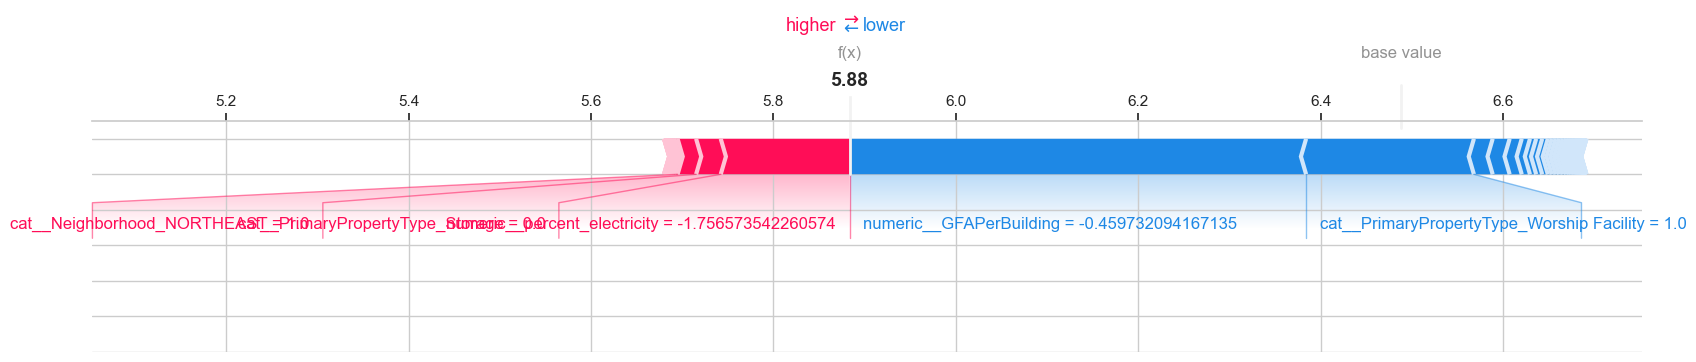

In [255]:
import matplotlib
shap.initjs()
explainer = shap.TreeExplainer(Lgbm_model.named_steps['Lgbm'] )
X_test_tranformed = Lgbm_model.named_steps['prepa'].transform(X_test)
dense_data = X_test_tranformed.toarray()
shap_values= explainer.shap_values(dense_data)


print("Number of features in X_test:", len(X_test.columns))
print("Feature names:", X_test.columns)
print("Number of features in shap_values:",shap_values.shape, "\n Number of features in X test transformed:",X_test_tranformed.shape, 
      "\nNumber of features in dense data:",dense_data.shape, "\nNumber of features in X_test:", X_test.shape )
# # plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value, shap_values[0,:], dense_data[0, :],feature_names=preprocessor.get_feature_names_out(), matplotlib=matplotlib)



Ce graphique montre l'importance des features pour une prédiction spécifique. 
Nous pouvons observer que la variable "percent_electricity"(en rouge) a une influence positive sur la prédiction, c'est-à-dire qu'une augmentation de cette variable entraîne une augmentation de la prédiction. 
En revanche, les variables "GFA_per_building" et "worship_Facility" (qui est une référence pour le type de bâtiment principal) ont une influence négative sur la prédiction, c'est-à-dire qu'une augmentation de ces variables entraîne une diminution de la prédiction.


(326, 164)


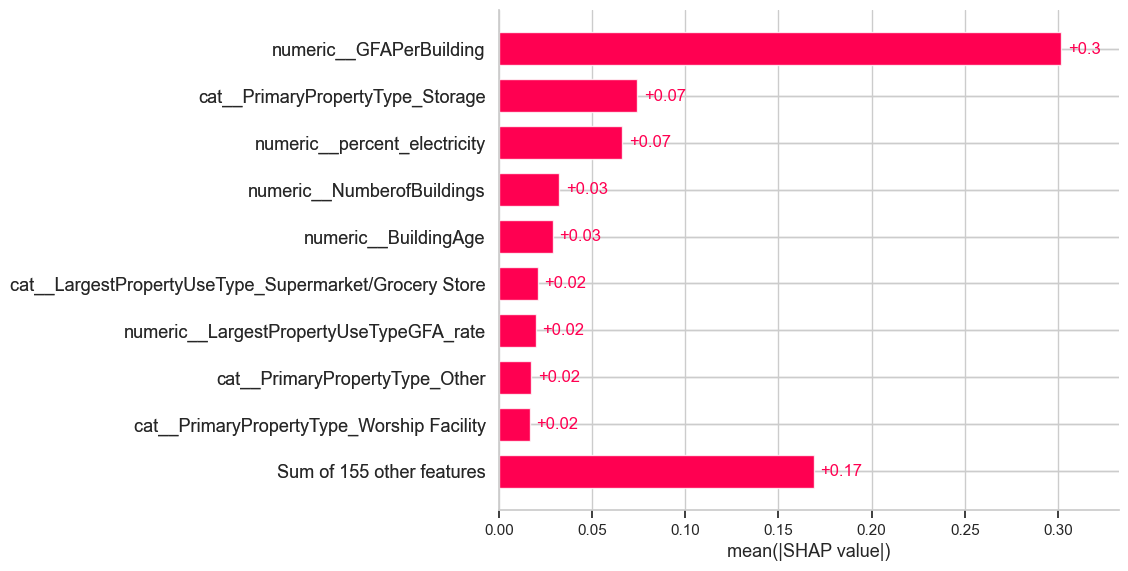

In [256]:
shap.initjs()
explainer = shap.Explainer(Lgbm_model.named_steps['Lgbm'])
X_test_transformed = Lgbm_model.named_steps['prepa'].transform(X_test)
dense_data = X_test_transformed.toarray()
shap_values = explainer.shap_values(dense_data)

# Créez un objet Explanation
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, data=dense_data, feature_names=preprocessor.get_feature_names_out())
print(explanation.shape)
# Utilisez shap.plots.waterfall avec l'objet Explanation
shap.plots.bar(explanation, max_display=10)

(326, 164)


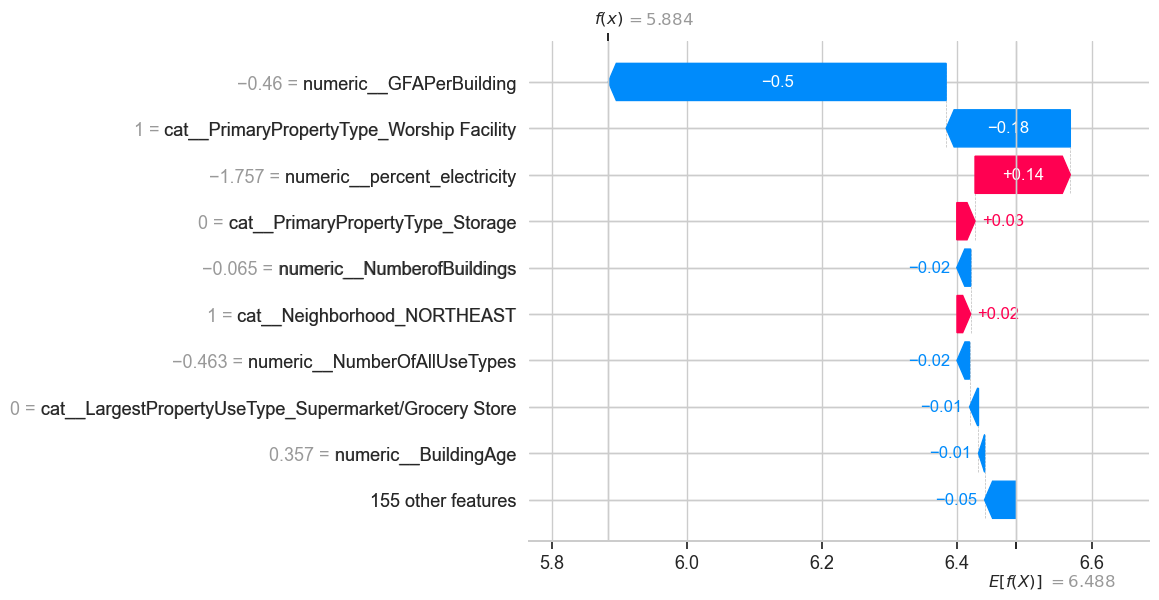

In [257]:
shap.initjs()
explainer =shap.TreeExplainer(Lgbm_model.named_steps['Lgbm'])
X_test_tranformed = Lgbm_model.named_steps['prepa'].transform(X_test)
dense_data = X_test_tranformed.toarray()
shap_values = explainer.shap_values(dense_data)
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, data=dense_data,feature_names=preprocessor.get_feature_names_out())
print(explanation.shape)
shap.plots.waterfall(explanation[0])

Dans le graphique waterfall de SHAP, nous pouvons observer l'importance globale des variables et leur influence sur la prédiction. Les variables "GFAPerBuilding" et "primaryPropertyType_worship_facility" ont une influence négative, ce qui signifie qu'une augmentation de ces variables entraîne une diminution de la prédiction. En revanche, les variables "percent_electricity" et "primaryPropertyType_worship_facility_storage" ont une influence positive, ce qui signifie qu'une augmentation de ces variables entraîne une augmentation de la prédiction.

# EnergyStar importance

In [258]:
data = data2[[ 'ENERGYSTARScore', "NumberofFloors",  "BuildingAge" ,"NumberofBuildings",
                "percent_electricity",
              "LargestPropertyUseTypeGFA_rate","SecondLargestPropertyUseTypeGFA_rate" ,"ThirdLargestPropertyUseTypeGFA_rate",  
              "PropertyGFAParking_rate",
              'SiteEnergyUse(kBtu)Log',  "PrimaryPropertyType",
             "Neighborhood" ,"NumberOfAllUseTypes",'GFAPerBuilding','GFAPerFloor',
             'LargestPropertyUseType',"SecondLargestPropertyUseType", "ThirdLargestPropertyUseType"]]
model_dataES_EU= data
model_dataES_EU.dropna(how = 'any', inplace=True)
X = model_dataES_EU.drop(['SiteEnergyUse(kBtu)Log'],axis=1) #TotalGHGEmissions
y = model_dataES_EU['SiteEnergyUse(kBtu)Log']
model_dataES_EU

,ENERGYSTARScore,NumberofFloors,BuildingAge,NumberofBuildings,percent_electricity,LargestPropertyUseTypeGFA_rate,SecondLargestPropertyUseTypeGFA_rate,ThirdLargestPropertyUseTypeGFA_rate,PropertyGFAParking_rate,SiteEnergyUse(kBtu)Log,PrimaryPropertyType,Neighborhood,NumberOfAllUseTypes,GFAPerBuilding,GFAPerFloor,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
0,60.0,12,89,1.0,54.605997,100.00,0.00,0.00,0.00,6.858920,Hospitality,DOWNTOWN,5,88434.0,7369.500,Hotel,no information,no information
1,61.0,11,20,1.0,38.660907,80.99,14.55,4.46,14.55,6.923655,Hospitality,DOWNTOWN,26,103566.0,9415.091,Hotel,Parking,Restaurant
2,43.0,41,47,1.0,68.230746,79.12,0.00,0.00,20.57,7.860859,Hospitality,DOWNTOWN,5,956110.0,23319.756,Hotel,no information,no information
3,56.0,10,90,1.0,40.751933,100.00,0.00,0.00,0.00,6.832163,Hospitality,DOWNTOWN,5,61320.0,6132.000,Hotel,no information,no information
4,75.0,18,36,1.0,37.880171,70.31,38.73,0.00,35.31,7.151450,Hospitality,DOWNTOWN,29,175580.0,9754.444,Hotel,Parking,Swimming Pool
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1612,9.0,2,87,1.0,49.020597,100.00,0.00,0.00,0.00,6.645486,Office,GREATER DUWAMISH,6,24990.0,12495.000,Office,no information,no information
1614,77.0,3,1,1.0,100.000000,101.62,0.00,0.00,0.00,6.122535,Education,GREATER DUWAMISH,20,45000.0,15000.000,K-12 School,Parking,no information
1623,75.0,1,64,1.0,100.000000,100.00,0.00,0.00,0.00,5.701282,Office,MAGNOLIA / QUEEN ANNE,6,13661.0,13661.000,Office,no information,no information
1626,93.0,1,56,1.0,71.565189,100.00,0.00,0.00,0.00,5.588620,Office,SOUTHEAST,6,15398.0,15398.000,Office,no information,no information


In [259]:

Lgbm_model_ES_EU =Pipeline([
    ('prepa', preprocessor),
    ('Lgbm', lgb.LGBMRegressor(learning_rate=0.1, max_depth=-1,n_estimators=75,num_leaves=25 , min_child_samples=5))
])
X_trainEU, X_testEU, y_trainEU, y_testEU = train_test_split(X, y,test_size=0.2,random_state=0)
# Ensuite, vous pouvez utiliser ce pipeline pour ajuster votre modèle
Lgbm_model_ES_EU.fit(X_trainEU, y_trainEU)

# Et également utiliser le pipeline pour faire des prédictions
predictions = Lgbm_model_ES_EU.predict(X_testEU, predict_disable_shape_check=True)
pipelines = {}
display(X_testEU)
#Lgbm_model = lgb.LGBMRegressor(learning_rate=1, max_depth=21,n_estimators=67,num_leaves=21 , min_child_samples=33)
result_Lgbm_ES_EU = evaluate_model(Lgbm_model_ES_EU, 'Lgbm', X, y, pipelines)
display(result_Lgbm_ES_EU)

,ENERGYSTARScore,NumberofFloors,BuildingAge,NumberofBuildings,percent_electricity,LargestPropertyUseTypeGFA_rate,SecondLargestPropertyUseTypeGFA_rate,ThirdLargestPropertyUseTypeGFA_rate,PropertyGFAParking_rate,PrimaryPropertyType,Neighborhood,NumberOfAllUseTypes,GFAPerBuilding,GFAPerFloor,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
318,96.0,6,12,1.0,100.000000,57.00,37.75,2.17,37.75,Office,LAKE UNION,54,139282.0,23213.667,Office,Parking,Financial Office
1512,1.0,1,45,1.0,80.342442,100.00,0.00,0.00,0.00,Storage,GREATER DUWAMISH,28,28320.0,28320.000,Distribution Center,Parking,no information
1028,92.0,2,92,1.0,18.050205,49.81,0.00,0.00,0.00,Education,DELRIDGE,11,42975.0,21487.500,K-12 School,no information,no information
656,95.0,2,87,1.0,70.351067,100.00,0.00,0.00,0.00,Office,DOWNTOWN,6,20028.0,10014.000,Office,no information,no information
773,49.0,3,28,1.0,52.220095,100.00,0.00,0.00,0.00,Residential,LAKE UNION,24,21118.0,7039.333,Residence Hall/Dormitory,no information,no information
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,92.0,2,91,1.0,36.826879,130.97,0.00,0.00,0.00,Education,CENTRAL,11,37327.0,18663.500,K-12 School,no information,no information
880,92.0,4,9,1.0,48.311246,64.39,33.05,0.00,38.08,Office,LAKE UNION,15,64596.0,16149.000,Office,Parking,no information
925,84.0,2,34,1.0,100.000000,98.73,0.00,0.00,0.00,Office,GREATER DUWAMISH,6,41262.0,20631.000,Office,no information,no information
724,94.0,6,107,1.0,29.905711,100.00,0.00,0.00,0.00,Hospitality,DOWNTOWN,5,35820.0,5970.000,Hotel,no information,no information


,RMSE Train,RMSE Test,R2 Train,R2 Test,MAE Test,Fit Time Test,Score Time Test
0,0.064685,0.195317,0.985998,0.802809,0.132484,0.195054,0.006058


(216, 114)


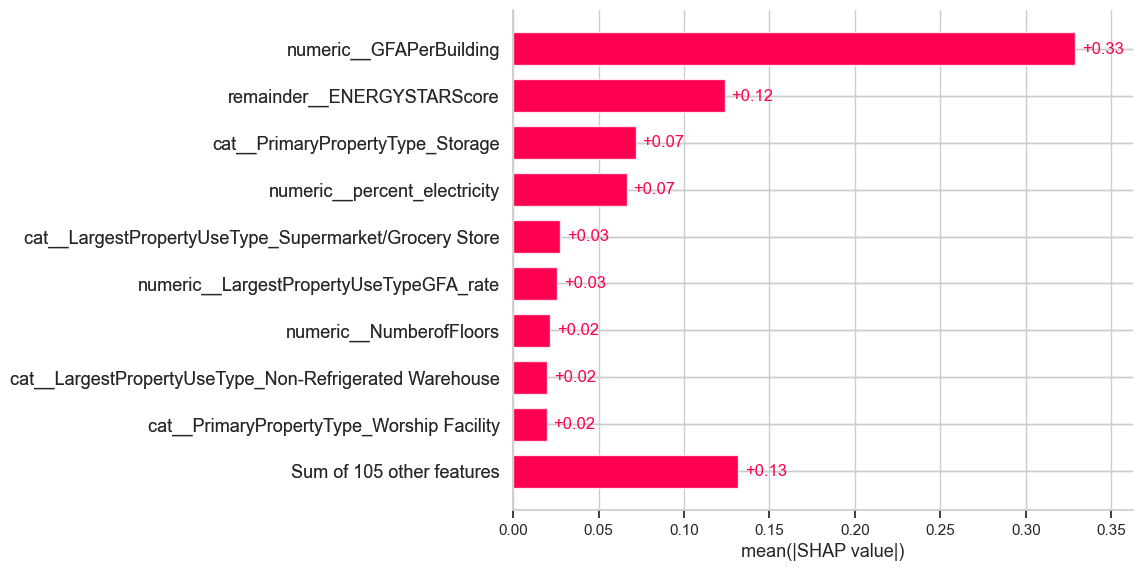

In [260]:
shap.initjs()

explainer = shap.Explainer(Lgbm_model_ES_EU.named_steps['Lgbm'])
X_test_transformed = Lgbm_model_ES_EU.named_steps['prepa'].transform(X_testEU)
dense_data = X_test_transformed.toarray()
shap_values = explainer.shap_values(dense_data)
#display(preprocessor.get_feature_names_out())
# Créez un objet Explanation
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, data=dense_data, feature_names=preprocessor.get_feature_names_out())
print(explanation.shape)
# Utilisez shap.plots.waterfall avec l'objet Explanation
shap.plots.bar(explanation, max_display=10)

In [261]:
model_dataES_EU_comp= model_dataES_EU
model_dataES_EU_comp=model_dataES_EU_comp.drop(['ENERGYSTARScore'],axis=1)

#model_dataES.dropna(how = 'any', inplace=True)
X = model_dataES_EU_comp.drop(['SiteEnergyUse(kBtu)Log'],axis=1) #TotalGHGEmissions
y = model_dataES_EU_comp['SiteEnergyUse(kBtu)Log']
model_dataES_EU_comp

,NumberofFloors,BuildingAge,NumberofBuildings,percent_electricity,LargestPropertyUseTypeGFA_rate,SecondLargestPropertyUseTypeGFA_rate,ThirdLargestPropertyUseTypeGFA_rate,PropertyGFAParking_rate,SiteEnergyUse(kBtu)Log,PrimaryPropertyType,Neighborhood,NumberOfAllUseTypes,GFAPerBuilding,GFAPerFloor,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
0,12,89,1.0,54.605997,100.00,0.00,0.00,0.00,6.858920,Hospitality,DOWNTOWN,5,88434.0,7369.500,Hotel,no information,no information
1,11,20,1.0,38.660907,80.99,14.55,4.46,14.55,6.923655,Hospitality,DOWNTOWN,26,103566.0,9415.091,Hotel,Parking,Restaurant
2,41,47,1.0,68.230746,79.12,0.00,0.00,20.57,7.860859,Hospitality,DOWNTOWN,5,956110.0,23319.756,Hotel,no information,no information
3,10,90,1.0,40.751933,100.00,0.00,0.00,0.00,6.832163,Hospitality,DOWNTOWN,5,61320.0,6132.000,Hotel,no information,no information
4,18,36,1.0,37.880171,70.31,38.73,0.00,35.31,7.151450,Hospitality,DOWNTOWN,29,175580.0,9754.444,Hotel,Parking,Swimming Pool
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1612,2,87,1.0,49.020597,100.00,0.00,0.00,0.00,6.645486,Office,GREATER DUWAMISH,6,24990.0,12495.000,Office,no information,no information
1614,3,1,1.0,100.000000,101.62,0.00,0.00,0.00,6.122535,Education,GREATER DUWAMISH,20,45000.0,15000.000,K-12 School,Parking,no information
1623,1,64,1.0,100.000000,100.00,0.00,0.00,0.00,5.701282,Office,MAGNOLIA / QUEEN ANNE,6,13661.0,13661.000,Office,no information,no information
1626,1,56,1.0,71.565189,100.00,0.00,0.00,0.00,5.588620,Office,SOUTHEAST,6,15398.0,15398.000,Office,no information,no information


In [262]:
Lgbm_model_ES_EU_comp =Pipeline([
    ('prepa', preprocessor),
    ('Lgbm', lgb.LGBMRegressor(learning_rate=0.1, max_depth=-1,n_estimators=75,num_leaves=25 , min_child_samples=5))
])
X_train_compEU, X_test_compEU, y_train_compEU, y_test_compEU = train_test_split(X, y,test_size=0.2,random_state=0)
# Ensuite, vous pouvez utiliser ce pipeline pour ajuster votre modèle
Lgbm_model_ES_EU_comp.fit(X_train_compEU, y_train_compEU)

# Et également utiliser le pipeline pour faire des prédictions
predictions = Lgbm_model_ES_EU_comp.predict(X_test_compEU, predict_disable_shape_check=True)
pipelines = {}
display(X_test_compEU)
#Lgbm_model = lgb.LGBMRegressor(learning_rate=1, max_depth=21,n_estimators=67,num_leaves=21 , min_child_samples=33)
result_Lgbm_ES_EU_comp = evaluate_model(Lgbm_model_ES_EU_comp, 'Lgbm', X, y, pipelines)
display(result_Lgbm_ES_EU_comp)

,NumberofFloors,BuildingAge,NumberofBuildings,percent_electricity,LargestPropertyUseTypeGFA_rate,SecondLargestPropertyUseTypeGFA_rate,ThirdLargestPropertyUseTypeGFA_rate,PropertyGFAParking_rate,PrimaryPropertyType,Neighborhood,NumberOfAllUseTypes,GFAPerBuilding,GFAPerFloor,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
318,6,12,1.0,100.000000,57.00,37.75,2.17,37.75,Office,LAKE UNION,54,139282.0,23213.667,Office,Parking,Financial Office
1512,1,45,1.0,80.342442,100.00,0.00,0.00,0.00,Storage,GREATER DUWAMISH,28,28320.0,28320.000,Distribution Center,Parking,no information
1028,2,92,1.0,18.050205,49.81,0.00,0.00,0.00,Education,DELRIDGE,11,42975.0,21487.500,K-12 School,no information,no information
656,2,87,1.0,70.351067,100.00,0.00,0.00,0.00,Office,DOWNTOWN,6,20028.0,10014.000,Office,no information,no information
773,3,28,1.0,52.220095,100.00,0.00,0.00,0.00,Residential,LAKE UNION,24,21118.0,7039.333,Residence Hall/Dormitory,no information,no information
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,2,91,1.0,36.826879,130.97,0.00,0.00,0.00,Education,CENTRAL,11,37327.0,18663.500,K-12 School,no information,no information
880,4,9,1.0,48.311246,64.39,33.05,0.00,38.08,Office,LAKE UNION,15,64596.0,16149.000,Office,Parking,no information
925,2,34,1.0,100.000000,98.73,0.00,0.00,0.00,Office,GREATER DUWAMISH,6,41262.0,20631.000,Office,no information,no information
724,6,107,1.0,29.905711,100.00,0.00,0.00,0.00,Hospitality,DOWNTOWN,5,35820.0,5970.000,Hotel,no information,no information


,RMSE Train,RMSE Test,R2 Train,R2 Test,MAE Test,Fit Time Test,Score Time Test
0,0.104996,0.25013,0.963043,0.671279,0.182585,0.120362,0.004934
